In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
from preprocessing.utils import *
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.patheffects as path_effects
import os
import pickle
import seaborn as sns

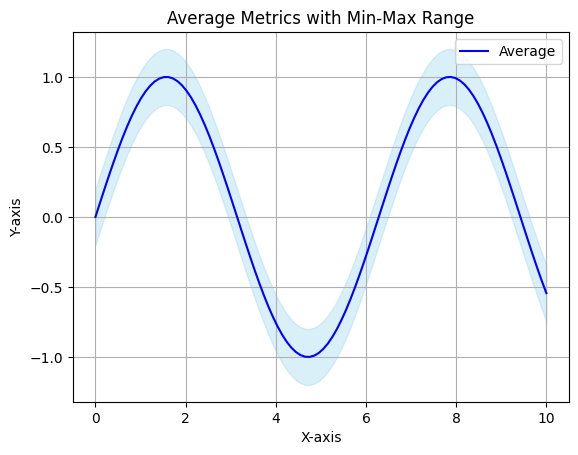

In [4]:
# Generate synthetic data
x = np.linspace(0, 10, 100)
y_avg = np.sin(x)
y_min = y_avg - 0.2
y_max = y_avg + 0.2

# Plot the average line
plt.plot(x, y_avg, color='blue', label='Average')

# Fill the region between min and max values
plt.fill_between(x, y_min, y_max, color='skyblue', alpha=0.3)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Average Metrics with Min-Max Range')
plt.legend()

# Show plot
plt.grid(True)
plt.show()


Is the distribution heavy-tailed? True


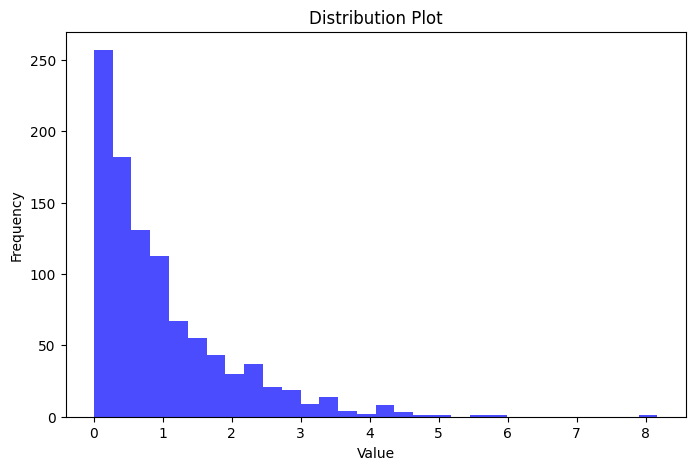

In [7]:
def is_heavy_tailed(data):
    """
    Checks if the distribution of the given data is heavy-tailed.
    
    Parameters:
    data (array-like): The data for which to check the tail behavior.
    
    Returns:
    bool: True if the distribution is heavy-tailed, False otherwise.
    """
    skewness = skew(data)
    kurt = kurtosis(data)
    
    # Thresholds for skewness and kurtosis to determine if distribution is heavy-tailed
    skew_threshold = 0
    kurtosis_threshold = 3
    
    return skewness > skew_threshold or kurt > kurtosis_threshold

def plot_distribution(data):
    """
    Plots the distribution of the given data.
    
    Parameters:
    data (array-like): The data to be plotted.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=30, color='blue', alpha=0.7)
    plt.title('Distribution Plot')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

# Example usage:
np.random.seed(42)
example_data = np.random.exponential(scale=1, size=1000)

# Check if the distribution is heavy-tailed
print("Is the distribution heavy-tailed?", is_heavy_tailed(example_data))

# Plot the distribution
plot_distribution(example_data)


In [3]:
def affine_renormalization_classification(results):
    """
    Perform affine renormalization on classification results.
    
    Parameters:
    results (list): List of original classification results between 0 and 1.
    
    Returns:
    list: List of renormalized classification results between 0 and 1.
    """
    # Find the top-performing model's accuracy
    top_accuracy = max(results)
    
    # Find the accuracy corresponding to the 10th percentile
    quantile_accuracy = np.percentile(results, 10)
    
    # Calculate the range of accuracies for renormalization
    range_accuracy = top_accuracy - quantile_accuracy
    
    # Perform affine renormalization for each accuracy
    renormalized_results = [(accuracy - quantile_accuracy) / range_accuracy for accuracy in results]
    
    return renormalized_results

# Example usage:
original_results = [0.7, 0.8, 0.6, 0.65, 0.9, 0.55, 0.75]  # Example list of original classification results
renormalized_results = affine_renormalization_classification(original_results)
print("Original results:", original_results)
print("Renormalized results:", renormalized_results)


Original results: [0.7, 0.8, 0.6, 0.65, 0.9, 0.55, 0.75]
Renormalized results: [0.3749999999999999, 0.6875000000000001, 0.06250000000000004, 0.21875000000000014, 1.0, -0.09374999999999972, 0.53125]


In [5]:
np.sort(original_results)

array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.9 ])

In [8]:
np.percentile(original_results, 99)

0.894

In [9]:
def affine_renormalization_regression(results):
    """
    Perform affine renormalization on regression results (R2 scores).
    
    Parameters:
    results (list): List of original regression results (R2 scores).
    
    Returns:
    list: List of renormalized regression results (R2 scores) between 0 and 1.
    """
    # Find the top-performing model's R2 score
    top_score = max(results)
    
    # Find the score corresponding to the 50th percentile
    quantile_score = np.percentile(results, 50)
    
    # Calculate the range of scores for renormalization
    range_score = top_score - quantile_score
    
    # Perform affine renormalization for each score
    renormalized_results = [(score - quantile_score) / range_score for score in results]
    
    # Clip negative scores to 0
    renormalized_results = [max(0, score) for score in renormalized_results]
    
    return renormalized_results

# Example usage:
original_results = [0.7, 0.8, 0.6, 0.65, 0.9, 0.55, 0.75]  # Example list of original regression results (R2 scores)
renormalized_results = affine_renormalization_regression(original_results)
print("Original results:", original_results)
print("Renormalized results:", renormalized_results)


Original results: [0.7, 0.8, 0.6, 0.65, 0.9, 0.55, 0.75]
Renormalized results: [0, 0.5000000000000002, 0, 0, 1.0, 0, 0.2500000000000001]


In [10]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from hyperopt import hp, tpe, fmin, Trials
import numpy as np

# Load dataset
boston = load_boston()
X = boston.data
y = boston.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the search space for hyperparameters
hyperparameter_space = {
    'n_estimators': hp.choice('n_estimators', np.arange(10, 1000, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(1, 20, dtype=int)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5)
}

# Define the objective function to minimize (e.g., mean squared error)
def objective_function(hyperparameters):
    model = RandomForestRegressor(**hyperparameters)
    score = -np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
    return score

# Perform hyperparameter tuning using random search
trials = Trials()
best_hyperparameters = fmin(objective_function, hyperparameter_space, algo=tpe.suggest, max_evals=400, trials=trials)

# Get the best hyperparameters
best_n_estimators = best_hyperparameters['n_estimators']
best_max_depth = best_hyperparameters['max_depth']
best_min_samples_split = best_hyperparameters['min_samples_split']
best_min_samples_leaf = best_hyperparameters['min_samples_leaf']

# Train the final model with the best hyperparameters
best_model = RandomForestRegressor(n_estimators=best_n_estimators,
                                   max_depth=best_max_depth,
                                   min_samples_split=best_min_samples_split,
                                   min_samples_leaf=best_min_samples_leaf)
best_model.fit(X_train, y_train)

# Evaluate the final model
test_mse = -np.mean(cross_val_score(best_model, X_test, y_test, cv=5, scoring='neg_mean_squared_error'))
print("Test MSE with best model:", test_mse)


ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [30]:
def split_data(X, y, isCategorical=None):
    # Shuffle the data
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    try :
        X = X.values
    except :
        pass
    
    try :
        y = y.values
    except :
        pass
    X = X[indices]
    y = y[indices]
    
    stratify = None if not isCategorical else y
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, random_state=42, stratify=stratify)
    stratify = None if not isCategorical else y_temp
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.7, random_state=42, stratify=stratify)
    print(X_test.shape, y_test.shape)
    num_val = min(X_val.shape[0], 50000)
    num_test = min(X_test.shape[0], 50000)
    
    X_val, y_val = X_val[:num_val], y_val[:num_val]
    X_test, y_test = X_test[:num_test], y_test[:num_test]
    print(X_test.shape, y_test.shape)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

REPO_ID = "inria-soda/tabular-benchmark"

df = pd.read_csv(
    hf_hub_download(repo_id=REPO_ID, filename=f'clf_cat/electricity.csv', repo_type="dataset")
)

# Split and preprocess the data
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X, y = preprocess_data(X, y, isCategorical=True)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(X, y, isCategorical=True)


Removed 0 rows with missing values on 38474 rows
Removed 0 columns with missing values on 8 columns
Removed 0 rows with missing values on 38474 rows
Removed 1 columns with pseudo-categorical values on 8 columns
high cardinality columns: Index([], dtype='object')
Removed 0 high-cardinality categorical features
(8081, 7) (8081,)
(3462, 7) (8081,)


In [16]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [24]:

X_test.shape

(3462, 7)

In [26]:
y_test.shape

(8081,)

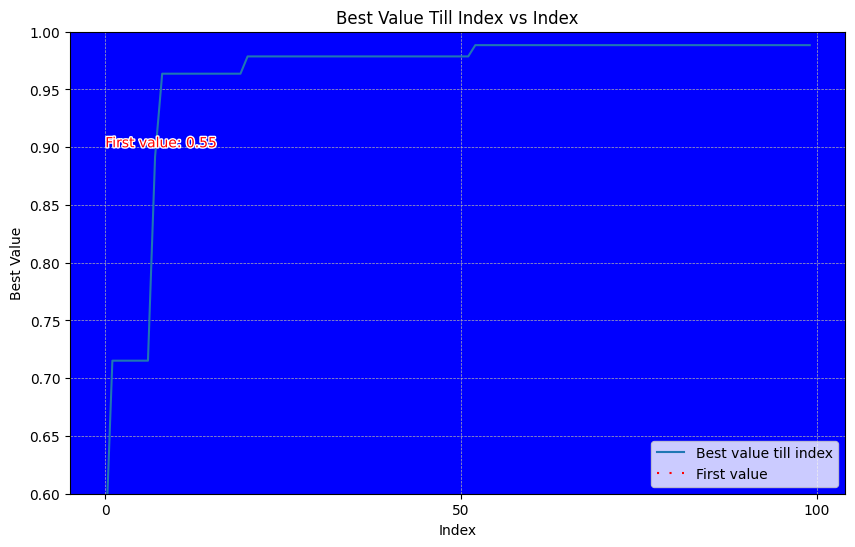

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get the current axis
ax.set_facecolor('blue')

# Step 1: Generate an array of random values
np.random.seed(0)  # For reproducibility
random_values = np.random.rand(100)

# Step 2: Create an array of the best values till each index
best_values = np.maximum.accumulate(random_values)

# Step 3: Plot the best values till index vs index
# plt.figure(figsize=(10, 6))
plt.plot(best_values, label='Best value till index')

# Plot the first value of random_values as a dotted horizontal line
first_value = random_values[0]
plt.axhline(y=first_value, color='r', linestyle=(0, (1, 5)), label='First value')

# Add text on top of the dotted line with a little space below
text = plt.text(0, 0.9, f'First value: {first_value:.2f}', color='r')
text.set_path_effects([path_effects.withStroke(linewidth=2, foreground='white')])

plt.xlabel('Index')
plt.ylabel('Best Value')
plt.title('Best Value Till Index vs Index')
plt.ylim(0.6, 1)  # Clipping the y-axis from 0.6 to 1

# Customize the x and y ticks for the grid lines
plt.xticks(np.arange(0, len(random_values) + 1, 50))
plt.yticks(np.arange(0.6, 1.05, 0.05))

# Add the grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend()
plt.show()


In [28]:
def load_pickle_files_to_dataframe(folder_path, datasetname):
    # List to store each file's data
    df = pd.DataFrame(dtype=np.float32)

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.pkl') and datasetname in filename:
            file_path = os.path.join(folder_path, filename)
            # Load the pickle file
            with open(file_path, 'rb') as file:
                data = pickle.load(file) #list of dctionaries
                for item in data :
                    col_names = []
                    values = []
                    for key, value in item.items() :
                        if key == 'hyperparameters':
                            for k2, v2 in value.items() :
                                col_names.append(k2)
                                values.append(v2)
                        else :
                            col_names.append(key)
                            values.append(value)
                    df.loc[df.shape[0], col_names] = values
                                
    return df

# Example usage:
folder_path = 'random-forest-results'
datasetname = 'default-of-credit-card-clients.csv'  # Dataset name to filter files
df = load_pickle_files_to_dataframe(folder_path, datasetname)
df

,val_accuracy,test_accuracy,train_accuracy,bootstrap,ccp_alpha,class_weight,criterion,max_depth,max_features,max_leaf_nodes,...,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,monotonic_cst,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
0,0.69598,0.700143,0.998278,True,0.0,None,gini,None,sqrt,None,...,1,2,0.0,None,100,None,False,None,0,False
1,0.694305,0.683286,0.983961,False,0.0,None,entropy,None,0.6,None,...,5,2,0.0,None,757,None,False,None,0,False
2,0.688442,0.695839,0.70366,True,0.0,None,entropy,3,None,None,...,20,2,0.0,None,518,None,False,None,0,False
3,0.680905,0.682927,0.695479,True,0.0,None,gini,2,0.6,None,...,5,2,0.0,None,944,None,False,None,0,False
4,0.70938,0.710545,0.783531,False,0.0,None,gini,None,sqrt,None,...,23,2,0.0,None,2894,None,False,None,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.70268,0.682927,0.998278,False,0.0,None,gini,None,0.6,None,...,1,2,0.0,None,70,None,False,None,0,False
246,0.69598,0.702654,0.820129,False,0.0,None,gini,None,0.4,None,...,18,2,0.0,None,18,None,False,None,0,False
247,0.70603,0.7066,0.844349,True,0.0,None,entropy,None,0.9,None,...,11,2,0.0,None,2213,None,False,None,0,False
248,0.69933,0.703013,0.715178,False,0.0,None,gini,3,sqrt,None,...,29,2,0.0,None,63,None,False,None,0,False


val_accuracy                 0.69598
test_accuracy               0.700143
train_accuracy              0.998278
bootstrap                       True
ccp_alpha                        0.0
class_weight                    None
criterion                       gini
max_depth                       None
max_features                    sqrt
max_leaf_nodes                  None
max_samples                     None
min_impurity_decrease            0.0
min_samples_leaf                   1
min_samples_split                  2
min_weight_fraction_leaf         0.0
monotonic_cst                   None
n_estimators                     100
n_jobs                          None
oob_score                      False
random_state                    None
verbose                            0
warm_start                     False
Name: 0, dtype: object

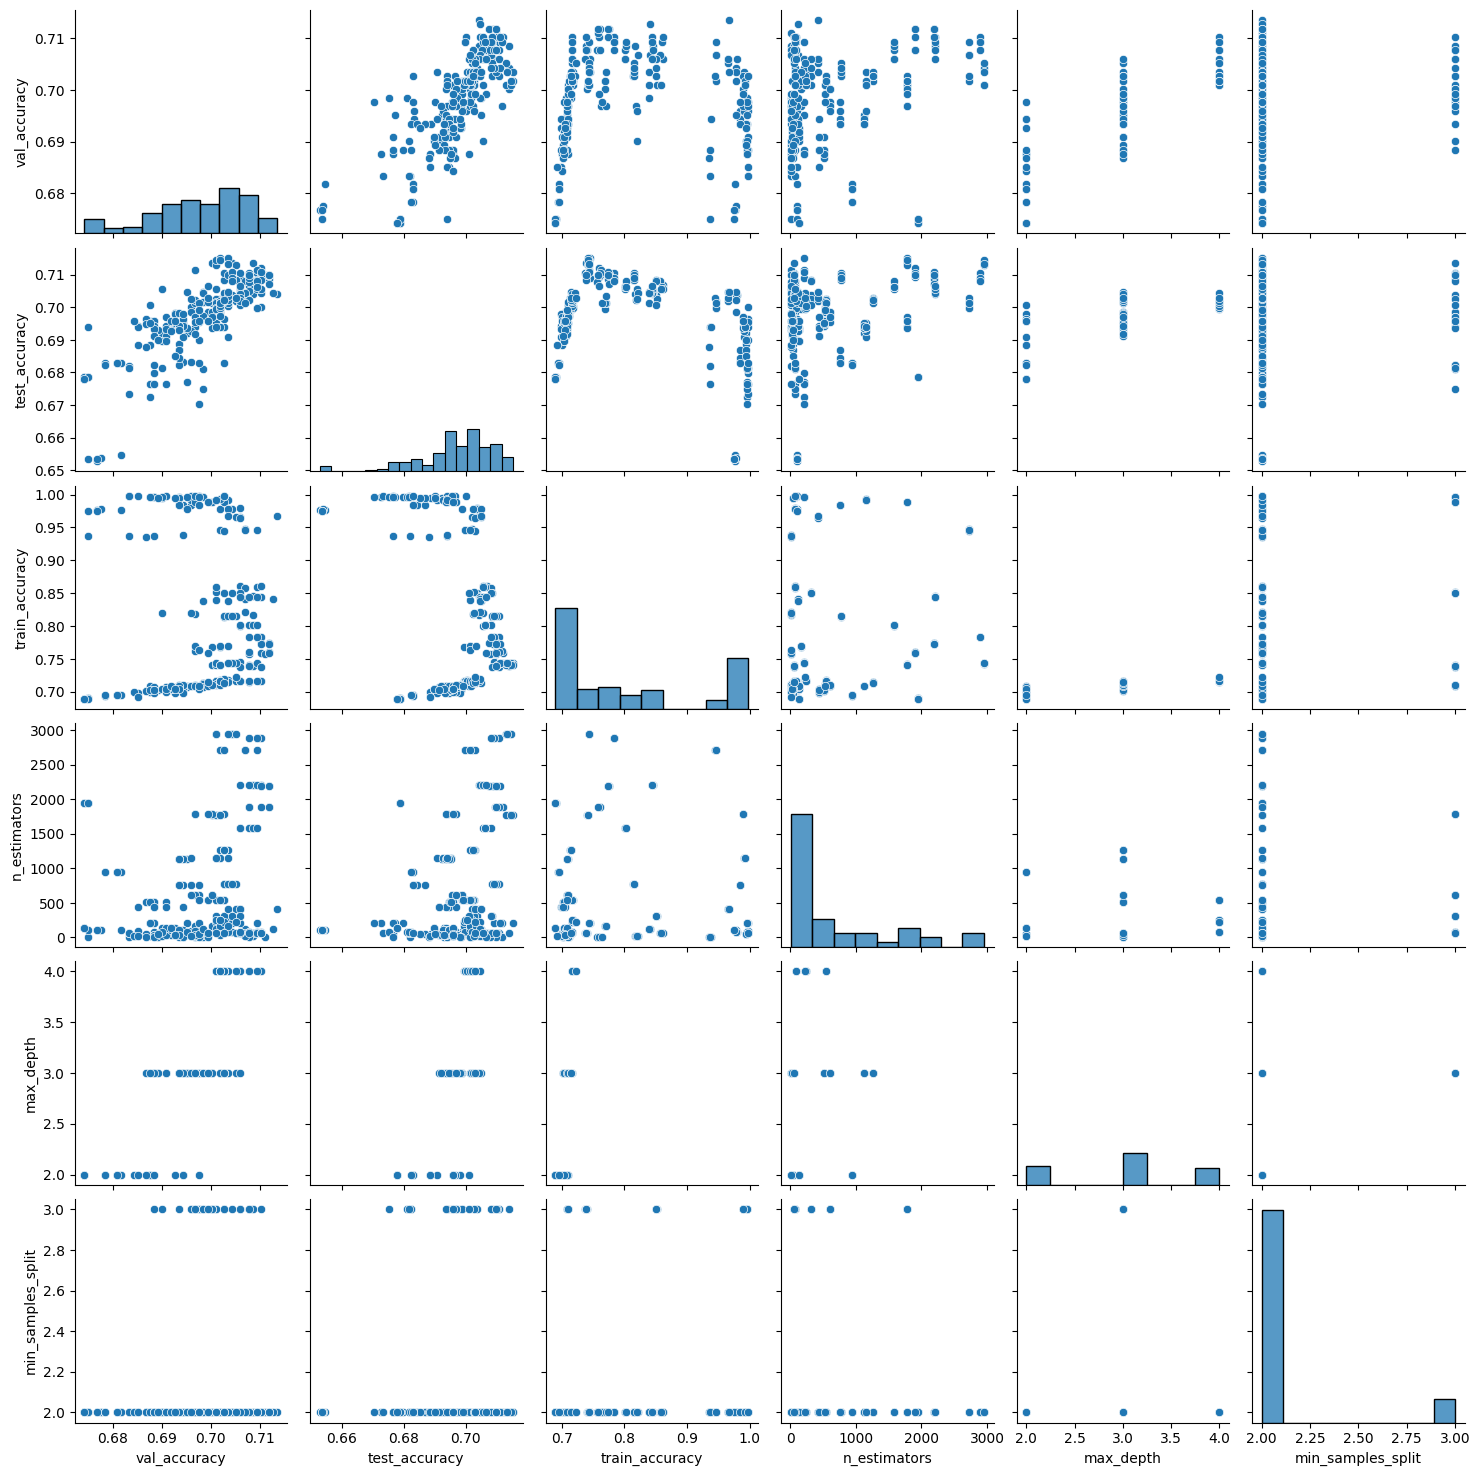

In [38]:
sns.pairplot(df[['val_accuracy', 'test_accuracy', 'train_accuracy', 'n_estimators', 'max_depth', 'min_samples_split']])


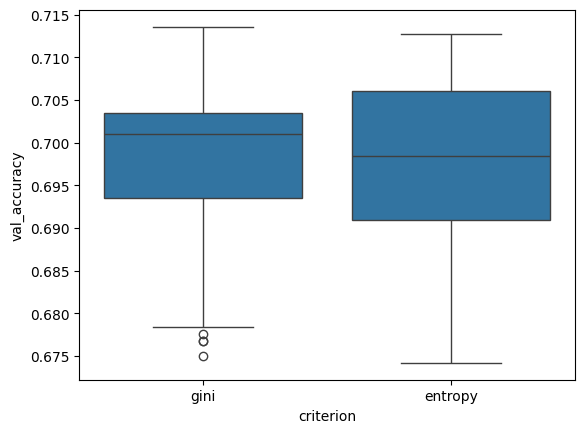

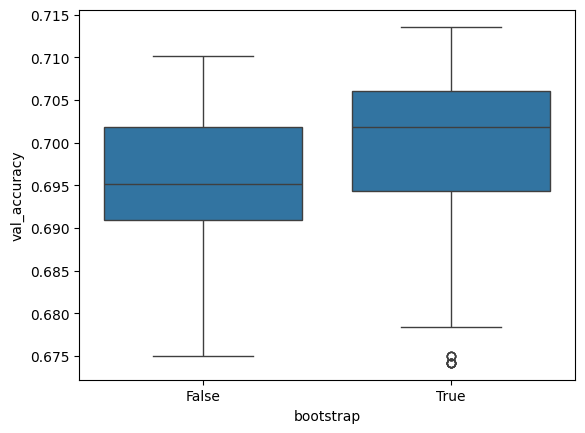

In [39]:
# Boxplot for criterion
sns.boxplot(x='criterion', y='val_accuracy', data=df)
plt.show()

# Boxplot for bootstrap
sns.boxplot(x='bootstrap', y='val_accuracy', data=df)
plt.show()


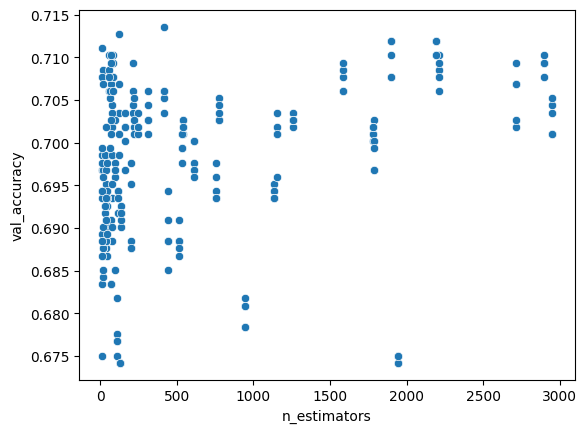

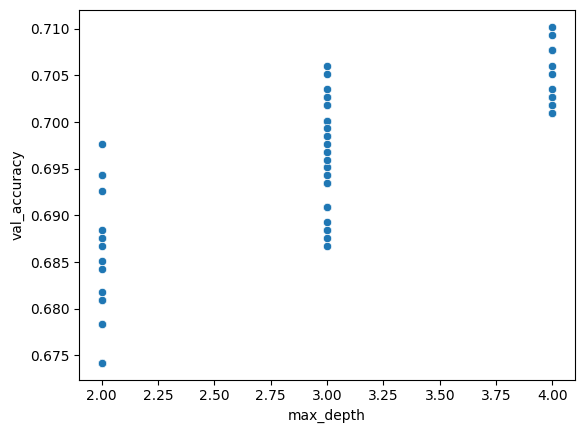

In [41]:
# Scatter plot for n_estimators vs val_accuracy
sns.scatterplot(x='n_estimators', y='val_accuracy', data=df)
plt.show()

# Scatter plot for max_depth vs val_accuracy
sns.scatterplot(x='max_depth', y='val_accuracy', data=df)
plt.show()


In [42]:
# Group by criterion and compute mean performance
criterion_group = df.groupby('criterion')[['val_accuracy', 'test_accuracy', 'train_accuracy']].mean()
print(criterion_group)

# Group by bootstrap and compute mean performance
bootstrap_group = df.groupby('bootstrap')[['val_accuracy', 'test_accuracy', 'train_accuracy']].mean()
print(bootstrap_group)

          val_accuracy test_accuracy train_accuracy
criterion                                          
entropy       0.697144      0.698231       0.782183
gini          0.697939      0.696003       0.823715
          val_accuracy test_accuracy train_accuracy
bootstrap                                          
False         0.696036      0.693326       0.816562
True          0.698921      0.700527       0.791218


In [44]:
from scipy.stats import ttest_ind

# Example: T-test between bootstrap True and False
bootstrap_true = df[df['bootstrap'] == True]['val_accuracy']
bootstrap_false = df[df['bootstrap'] == False]['val_accuracy']

t_stat, p_val = ttest_ind(bootstrap_true, bootstrap_false)
print(f'T-test result: t-statistic={t_stat}, p-value={p_val}')


ValueError: data type <class 'numpy.object_'> not inexact